In [88]:
from functions import *

In [89]:
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import glob
import time
from datetime import datetime
from collections import Counter
from PIL import Image

# Visualize one experiment

In [90]:
model='baseline_CNN'
exp = 83
spl = 1

#### Experiment details

In [91]:
df1=pd.read_excel(f'../official_results/{model}_results.xlsx')
df2=pd.read_excel(f'../official_results/old/{model}_results.xlsx')
df = pd.concat([df1, df2], ignore_index = True)
df['Normalized Variables'] = df['Variables'].apply(
    lambda x: ', '.join(sorted(x.split(', '))))


In [92]:
# Define mapping for concise names
variable_set_mapping = {
    'lst': 'LST',
    'lst, ndvi': 'LST + NDVI',
    'altitude, direction, lst, ndvi, slope': 'All Image Features',
    'discharge, lat, lon, lst, month, ndvi': 'LST + NDVI + Non-image Features',
    'altitude, direction, discharge, lat, lon, lst, month, ndvi, slope': 'Full Features'
}

# Apply mapping
df['Normalized Variables'] = df['Normalized Variables'].map(variable_set_mapping)
df

,Experiment,RMSE,Variables,Input,Split,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
0,1,5.683873,lst,74 cells,stratified,3,Adam,1487,32,57 of 300,2024-11-20,10:35:18,259.58,Physics-guided,8,LST
1,2,5.095058,lst,74 cells,stratified,3,Adam,1487,32,54 of 300,2024-11-20,10:39:12,232.63,RMSE,8,LST
2,3,5.064375,lst,74 cells,stratified,3,Adam,1487,64,102 of 300,2024-11-20,10:49:56,292.51,Physics-guided,8,LST
3,4,4.963711,lst,74 cells,stratified,3,Adam,1487,64,119 of 300,2024-11-20,10:55:22,323.51,RMSE,8,LST
4,3,5.005169,lst,74 cells,stratified,3,Adam,1487,128,74 of 300,2024-11-20,10:57:50,146.31,Physics-guided,8,LST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,6,5.205161,lst,74 cells,stratified,2,Adam,1487,128,123 of 300,2024-11-19,15:47:30,265.10,Physics-guided,64,LST
164,6,4.778100,lst,74 cells,stratified,3,Adam,1487,64,108 of 300,2024-11-19,15:48:31,301.57,RMSE,64,LST
165,7,5.102246,lst,74 cells,stratified,2,Adam,1487,128,138 of 300,2024-11-19,15:52:23,290.87,RMSE,64,LST
166,6,4.888248,lst,74 cells,stratified,3,Adam,1487,128,149 of 300,2024-11-19,15:53:35,301.87,Physics-guided,64,LST


In [93]:
# Best experiment
rmse_mean = df.groupby(['Batch size', 'Resolution', 'Optimizer', 'Normalized Variables'])['RMSE'].mean().reset_index()

rmse_mean = rmse_mean.sort_values(by='RMSE')
rmse_mean.head()

,Batch size,Resolution,Optimizer,Normalized Variables,RMSE
39,128,16,Adam,LST + NDVI,4.796014
34,128,8,Adam,LST + NDVI,4.856707
18,64,16,Adam,All Image Features,4.858441
42,128,32,Adam,Full Features,4.897588
16,64,8,Adam,LST + NDVI,4.905866


In [94]:
df[df.RMSE == df['RMSE'].min()]

,Experiment,RMSE,Variables,Input,Split,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
64,54,4.634157,"lst, ndvi, slope, direction, altitude",74 cells,stratified,2,Adam,1487,64,92 of 300,2024-11-20,17:00:31,263.09,RMSE,8,All Image Features


In [95]:
best_experiments = rmse_mean.head()
filtered_df = df.merge(best_experiments, on=['Batch size', 'Resolution', 'Optimizer', 'Normalized Variables'], how='inner')
filtered_df

,Experiment,RMSE_x,Variables,Input,Split,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables,RMSE_y
0,50,4.848934,"lst, ndvi, slope, direction, altitude, month, ...",74 cells,stratified,1,Adam,1487,128,76 of 300,2024-11-20,16:12:50,174.65,RMSE,32,Full Features,4.897588
1,50,4.783714,"lst, ndvi, slope, direction, altitude, month, ...",74 cells,stratified,2,Adam,1487,128,57 of 300,2024-11-20,16:12:54,129.75,RMSE,32,Full Features,4.897588
2,52,5.060118,"lst, ndvi, altitude, direction, slope, month, ...",74 cells,stratified,3,Adam,1487,128,60 of 300,2024-11-20,16:18:36,137.81,RMSE,32,Full Features,4.897588
3,53,5.009115,"lst, ndvi, slope, direction, altitude",74 cells,stratified,1,Adam,1487,64,78 of 300,2024-11-20,16:56:52,226.94,RMSE,16,All Image Features,4.858441
4,54,4.803296,"lst, ndvi, slope, direction, altitude",74 cells,stratified,2,Adam,1487,64,88 of 300,2024-11-20,17:01:12,258.13,RMSE,16,All Image Features,4.858441
5,55,4.762912,"lst, ndvi, slope, direction, altitude",74 cells,stratified,3,Adam,1487,64,75 of 300,2024-11-20,17:04:52,218.35,RMSE,16,All Image Features,4.858441
6,83,4.927931,"lst, ndvi",74 cells,stratified,1,Adam,1487,64,88 of 300,2024-11-21,11:15:30,256.28,RMSE,8,LST + NDVI,4.905866
7,84,4.919010,"lst, ndvi",74 cells,stratified,2,Adam,1487,64,92 of 300,2024-11-21,11:19:59,267.50,RMSE,8,LST + NDVI,4.905866
8,85,4.870656,"lst, ndvi",74 cells,stratified,3,Adam,1487,64,85 of 300,2024-11-21,11:24:11,249.42,RMSE,8,LST + NDVI,4.905866
9,83,4.771601,"lst, ndvi",74 cells,stratified,1,Adam,1487,128,139 of 300,2024-11-21,11:34:32,279.55,RMSE,8,LST + NDVI,4.856707


#### Learning curve

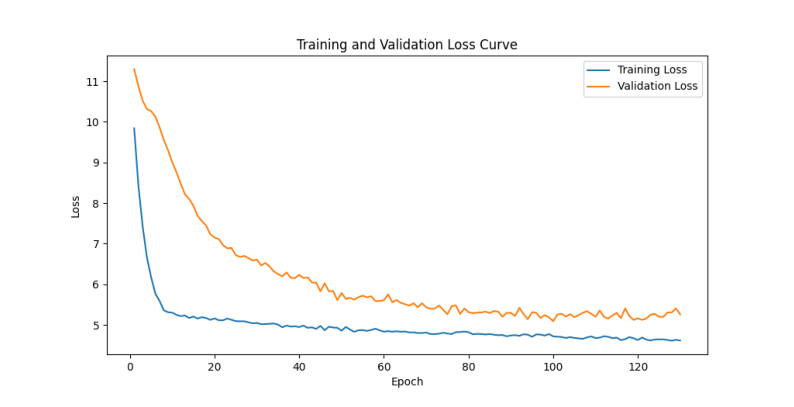

In [96]:
image_path = f'../official_results/learning_curves/{model}_exp_{exp}_split_{spl}.png'
image = Image.open(image_path)
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()


#### Error log

In [97]:
errors_df = pd.read_csv(f'../official_results/error_logs/{model}_exp_{exp}_split_{spl}.csv')

In [98]:
errors_df_filt = errors_df[errors_df['epoch'] <= 100]

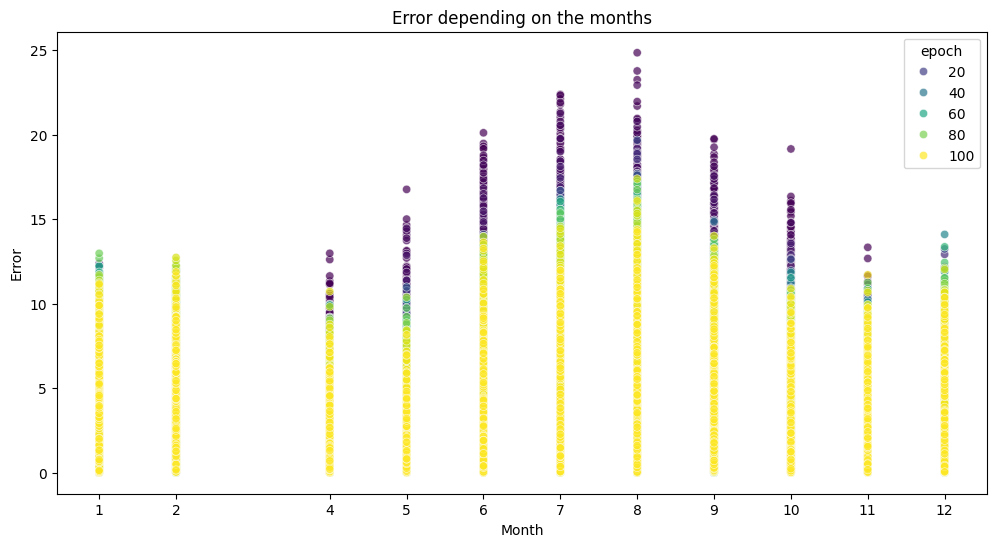

In [99]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=errors_df_filt, x="month", y="error", hue="epoch", palette="viridis", alpha=0.7)
plt.xticks(ticks=sorted(errors_df_filt["month"].unique()))
plt.title("Error depending on the months")
plt.xlabel("Month")
plt.ylabel('Error')
plt.show()

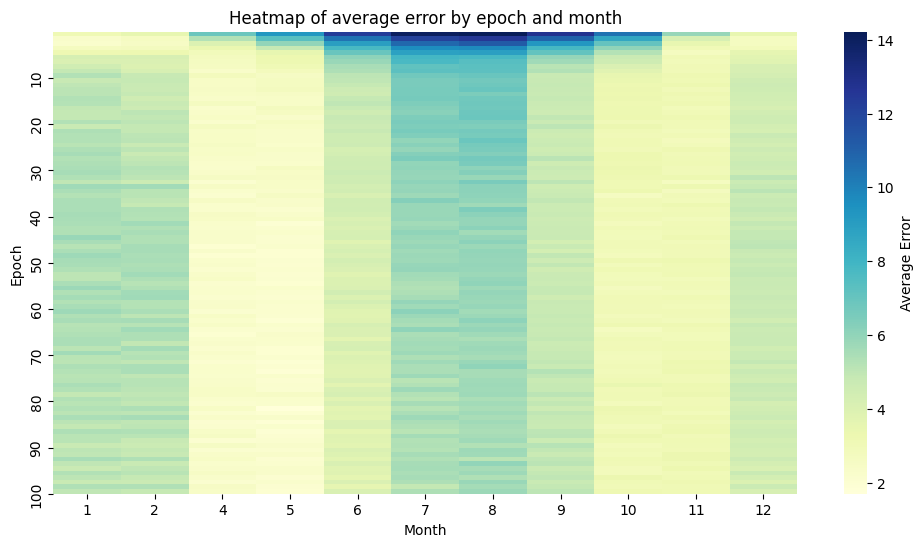

In [100]:
epochs = len(errors_df_filt.epoch.unique())
pivot_table = errors_df_filt.pivot_table(values="error", index="epoch", columns="month", aggfunc="mean")
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap="YlGnBu", cbar_kws={'label': 'Average Error'})
if epochs == 10:
    ticks = range(epochs + 1)
    labelss = [str(i) for i in range(epochs + 1)]
else:
    ticks = [i for i in range(10, epochs + 1, 10)]
    labelss = [str(i) for i in range(10, epochs + 1, 10)]
plt.yticks(ticks=ticks,labels=labelss)
plt.title("Heatmap of average error by epoch and month")
plt.xlabel("Month")
plt.ylabel("Epoch")
plt.show()

# Analysis of all baseline experiments

### Compare RMSE for all baseline experiments

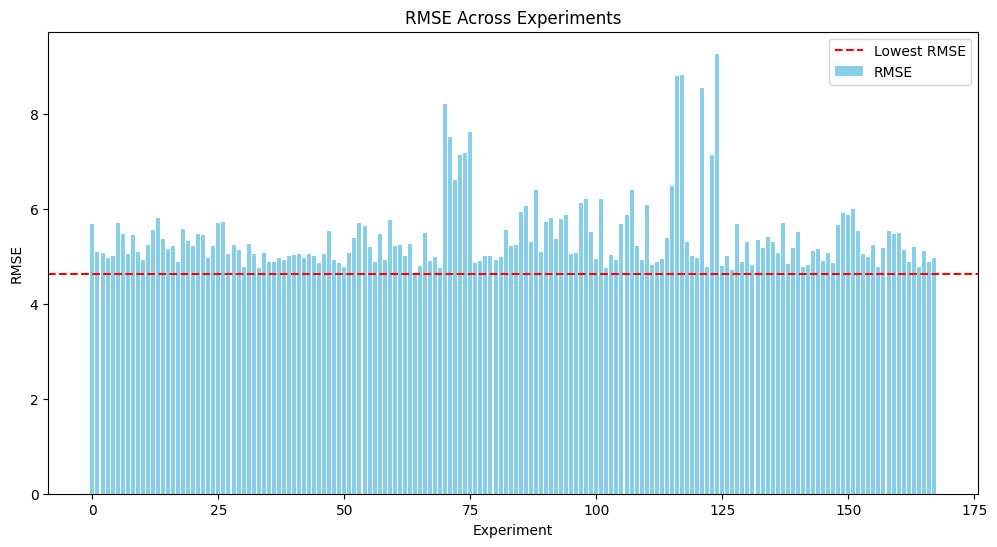

In [101]:
plt.figure(figsize=(12, 6))
plt.bar(df.index, df['RMSE'], color='skyblue', label="RMSE")
plt.axhline(y=df['RMSE'].min(), color='red', linestyle='--', label="Lowest RMSE")
plt.xlabel('Experiment')
plt.ylabel('RMSE')
plt.title('RMSE Across Experiments')
plt.legend()
plt.show()

### Best batch and resolution combination

In [102]:
mean_rmse = df.groupby(["Resolution", "Batch size", "Loss"])["RMSE"].mean().reset_index()

# Identificar la combinación con el menor RMSE
best_combination = mean_rmse.loc[mean_rmse["RMSE"].idxmin()]
print(best_combination)
best_experiments = df[
    (df["Resolution"] == best_combination["Resolution"]) &
    (df["Batch size"] == best_combination["Batch size"]) &
    (df["Loss"] == best_combination["Loss"])
]

# Mostrar todas las variables para estas filas
print("Best Experiments Details:")
best_experiments

Resolution          64
Batch size         128
Loss              RMSE
RMSE          4.972745
Name: 23, dtype: object
Best Experiments Details:


,Experiment,RMSE,Variables,Input,Split,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
142,126,4.815280,"lst, ndvi, month, discharge, lat, lon",74 cells,stratified,1,Adam,1487,128,113 of 300,2024-11-21,12:41:03,254.29,RMSE,64,LST + NDVI + Non-image Features
143,127,5.120828,"lst, ndvi, month, discharge, lat, lon",74 cells,stratified,2,Adam,1487,128,51 of 300,2024-11-21,12:43:01,116.07,RMSE,64,LST + NDVI + Non-image Features
144,128,5.147548,"lst, ndvi, month, discharge, lat, lon",74 cells,stratified,3,Adam,1487,128,56 of 300,2024-11-21,12:45:12,128.07,RMSE,64,LST + NDVI + Non-image Features
145,126,4.905200,"lst, ndvi",74 cells,stratified,1,Adam,1487,128,154 of 300,2024-11-21,12:50:28,314.36,RMSE,64,LST + NDVI
146,127,5.064617,"lst, ndvi",74 cells,stratified,2,Adam,1487,128,154 of 300,2024-11-21,12:55:43,312.24,RMSE,64,LST + NDVI
147,128,4.855098,"lst, ndvi",74 cells,stratified,3,Adam,1487,128,123 of 300,2024-11-21,12:59:56,251.59,RMSE,64,LST + NDVI
156,4,4.775533,lst,74 cells,stratified,1,Adam,1487,128,111 of 300,2024-11-19,15:31:48,233.60,RMSE,64,LST
165,7,5.102246,lst,74 cells,stratified,2,Adam,1487,128,138 of 300,2024-11-19,15:52:23,290.87,RMSE,64,LST
167,7,4.968356,lst,74 cells,stratified,3,Adam,1487,128,144 of 300,2024-11-19,15:58:21,284.47,RMSE,64,LST


# Training parameters experimentation

## Image resolution and batch size analysis

### Best combination (splits mean) w/lst

In [103]:
df_lst = df[df.Variables=='lst']
mean_rmse = df_lst.groupby(["Resolution", "Batch size", "Loss"])["RMSE"].mean().reset_index()

# Identificar la combinación con el menor RMSE
best_combination = mean_rmse.loc[mean_rmse["RMSE"].idxmin()]
print(best_combination)
best_experiments = df_lst[
    (df["Resolution"] == best_combination["Resolution"]) &
    (df["Batch size"] == best_combination["Batch size"]) &
    (df["Loss"] == best_combination["Loss"])
]

# Mostrar todas las variables para estas filas
print("Best Experiments Details:")
best_experiments

Resolution          32
Batch size         128
Loss              RMSE
RMSE          4.928611
Name: 17, dtype: object
Best Experiments Details:


/tmp/ipykernel_276975/3972614768.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_experiments = df_lst[


,Experiment,RMSE,Variables,Input,Split,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
17,14,4.870761,lst,74 cells,stratified,3,Adam,1487,128,124 of 300,2024-11-20,12:41:19,243.46,RMSE,32,LST
35,20,4.871874,lst,74 cells,stratified,1,Adam,1487,128,193 of 300,2024-11-20,13:59:44,378.09,RMSE,32,LST
36,37,4.885543,lst,74 cells,stratified,1,SGD,1487,128,111 of 300,2024-11-20,14:24:39,181.10,RMSE,32,LST
37,37,4.962777,lst,74 cells,stratified,2,SGD,1487,128,137 of 300,2024-11-20,14:26:24,218.26,RMSE,32,LST
38,39,4.923957,lst,74 cells,stratified,3,SGD,1487,128,109 of 300,2024-11-20,14:37:29,179.43,RMSE,32,LST
39,40,5.013146,lst,74 cells,stratified,2,Adam,1487,128,149 of 300,2024-11-20,14:49:25,300.96,RMSE,32,LST
42,43,4.972216,lst,74 cells,stratified,1,"SGD w/ dynamic-lr, momentum 0.9 & nesterov",1487,128,104 of 300,2024-11-20,15:22:32,178.70,RMSE,32,LST


In [104]:
# Ordenar las combinaciones por RMSE promedio
mean_rmse_sorted = mean_rmse.sort_values("RMSE")

print("Top Combinations by Average RMSE:")
print(mean_rmse_sorted.head(10))  # Ver las 10 mejores combinaciones


Top Combinations by Average RMSE:
    Resolution  Batch size            Loss      RMSE
17          32         128            RMSE  4.928611
23          64         128            RMSE  4.948712
3            8          64            RMSE  4.967539
21          64          64            RMSE  4.987893
10          16         128  Physics-guided  4.988699
11          16         128            RMSE  4.996619
4            8         128  Physics-guided  5.027155
22          64         128  Physics-guided  5.027264
16          32         128  Physics-guided  5.090772
9           16          64            RMSE  5.104628


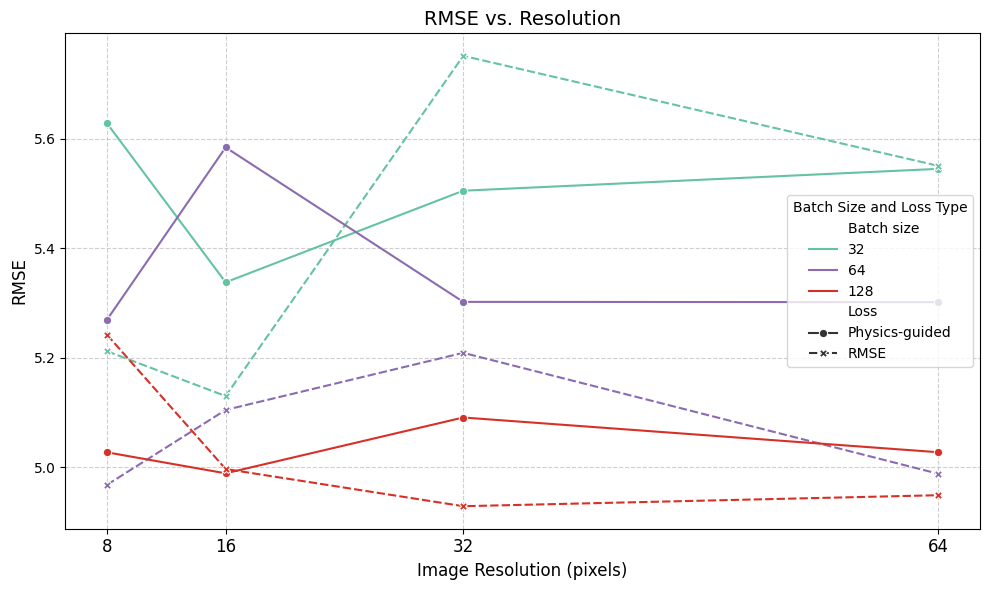

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

custom_palette = {
    32: "#66c2a4",  # Verde
    64: "#8c6bb1",  # Lila
    128: "#d73027"  # Rojo
}
# Crear un gráfico para los datos filtrados
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=mean_rmse,
    x="Resolution",
    y="RMSE",
    hue="Batch size",
    style="Loss",  # Diferenciar por tipo de Loss
    markers=True,
    palette=custom_palette  # Paleta de colores
)

resolutions_used = sorted(mean_rmse["Resolution"].unique())  # Obtener resoluciones únicas para este Split_id
plt.xticks(resolutions_used, labels=[str(res) for res in resolutions_used], fontsize=12)


# Configurar título y ejes
plt.title(f"RMSE vs. Resolution", fontsize=14)
plt.xlabel("Image Resolution (pixels)", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.legend(title="Batch Size and Loss Type", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


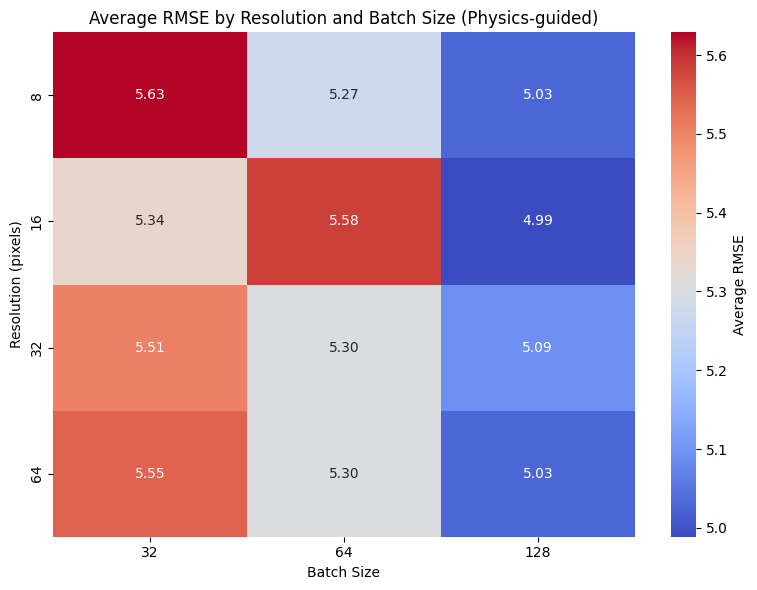

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar por tipo de Loss (por ejemplo, "Physics-guided")
physics_mean_rmse = mean_rmse[mean_rmse["Loss"] == "Physics-guided"].pivot(
    index="Resolution", columns="Batch size", values="RMSE"
)

plt.figure(figsize=(8, 6))
sns.heatmap(physics_mean_rmse, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Average RMSE'})
plt.title("Average RMSE by Resolution and Batch Size (Physics-guided)")
plt.xlabel("Batch Size")
plt.ylabel("Resolution (pixels)")
plt.tight_layout()
plt.show()


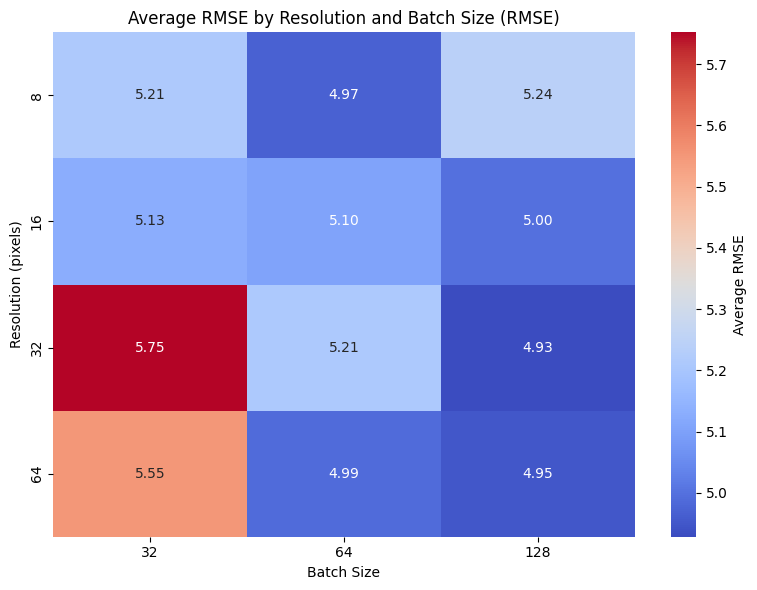

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar por tipo de Loss (por ejemplo, "Physics-guided")
physics_mean_rmse = mean_rmse[mean_rmse["Loss"] == "RMSE"].pivot(
    index="Resolution", columns="Batch size", values="RMSE"
)

plt.figure(figsize=(8, 6))
sns.heatmap(physics_mean_rmse, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Average RMSE'})
plt.title("Average RMSE by Resolution and Batch Size (RMSE)")
plt.xlabel("Batch Size")
plt.ylabel("Resolution (pixels)")
plt.tight_layout()
plt.show()


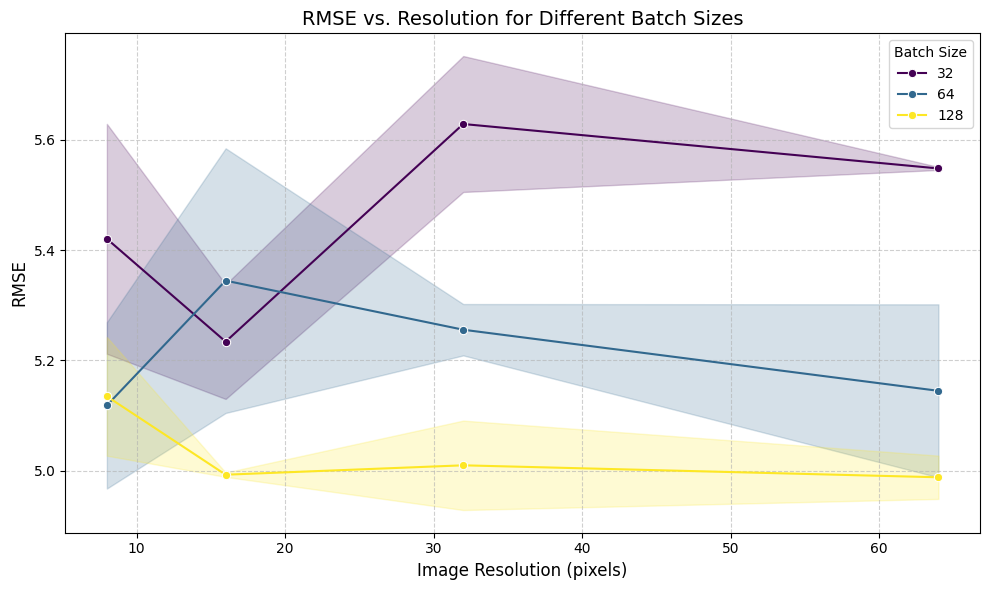

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de líneas para cada batch size
plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_rmse, x="Resolution", y="RMSE", hue="Batch size", marker="o", palette="viridis")
plt.title("RMSE vs. Resolution for Different Batch Sizes", fontsize=14)
plt.xlabel("Image Resolution (pixels)", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.legend(title="Batch Size", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## Optimizer analysis

In [109]:
best_results = df_lst[(df_lst.Resolution==32)&(df['Batch size']==128)&(df['Loss']=='RMSE')]
best_results

/tmp/ipykernel_276975/1765643091.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_results = df_lst[(df_lst.Resolution==32)&(df['Batch size']==128)&(df['Loss']=='RMSE')]


,Experiment,RMSE,Variables,Input,Split,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
17,14,4.870761,lst,74 cells,stratified,3,Adam,1487,128,124 of 300,2024-11-20,12:41:19,243.46,RMSE,32,LST
35,20,4.871874,lst,74 cells,stratified,1,Adam,1487,128,193 of 300,2024-11-20,13:59:44,378.09,RMSE,32,LST
36,37,4.885543,lst,74 cells,stratified,1,SGD,1487,128,111 of 300,2024-11-20,14:24:39,181.10,RMSE,32,LST
37,37,4.962777,lst,74 cells,stratified,2,SGD,1487,128,137 of 300,2024-11-20,14:26:24,218.26,RMSE,32,LST
38,39,4.923957,lst,74 cells,stratified,3,SGD,1487,128,109 of 300,2024-11-20,14:37:29,179.43,RMSE,32,LST
39,40,5.013146,lst,74 cells,stratified,2,Adam,1487,128,149 of 300,2024-11-20,14:49:25,300.96,RMSE,32,LST
42,43,4.972216,lst,74 cells,stratified,1,"SGD w/ dynamic-lr, momentum 0.9 & nesterov",1487,128,104 of 300,2024-11-20,15:22:32,178.70,RMSE,32,LST


In [110]:
rmse_mean = best_results.groupby('Optimizer')['RMSE'].mean().reset_index()

rmse_mean = rmse_mean.sort_values(by='RMSE')

print(rmse_mean)

                                    Optimizer      RMSE
0                                        Adam  4.918594
1                                         SGD  4.924092
2  SGD w/ dynamic-lr, momentum 0.9 & nesterov  4.972216


# Variables experimentation

In [111]:
df_vars = df[(df.Optimizer=='Adam')&(df.Loss=='RMSE')]
df_vars

,Experiment,RMSE,Variables,Input,Split,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables
1,2,5.095058,lst,74 cells,stratified,3,Adam,1487,32,54 of 300,2024-11-20,10:39:12,232.63,RMSE,8,LST
3,4,4.963711,lst,74 cells,stratified,3,Adam,1487,64,119 of 300,2024-11-20,10:55:22,323.51,RMSE,8,LST
5,4,5.699383,lst,74 cells,stratified,3,Adam,1487,128,61 of 300,2024-11-20,10:59:52,120.38,RMSE,8,LST
7,8,5.048740,lst,74 cells,stratified,3,Adam,1487,32,66 of 300,2024-11-20,11:28:42,284.93,RMSE,16,LST
9,8,5.082832,lst,74 cells,stratified,3,Adam,1487,64,98 of 300,2024-11-20,11:38:02,270.29,RMSE,16,LST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,5,5.474342,lst,74 cells,stratified,3,Adam,1487,32,46 of 300,2024-11-19,15:37:45,200.47,RMSE,64,LST
161,6,5.138928,lst,74 cells,stratified,2,Adam,1487,64,64 of 300,2024-11-19,15:43:03,186.65,RMSE,64,LST
164,6,4.778100,lst,74 cells,stratified,3,Adam,1487,64,108 of 300,2024-11-19,15:48:31,301.57,RMSE,64,LST
165,7,5.102246,lst,74 cells,stratified,2,Adam,1487,128,138 of 300,2024-11-19,15:52:23,290.87,RMSE,64,LST


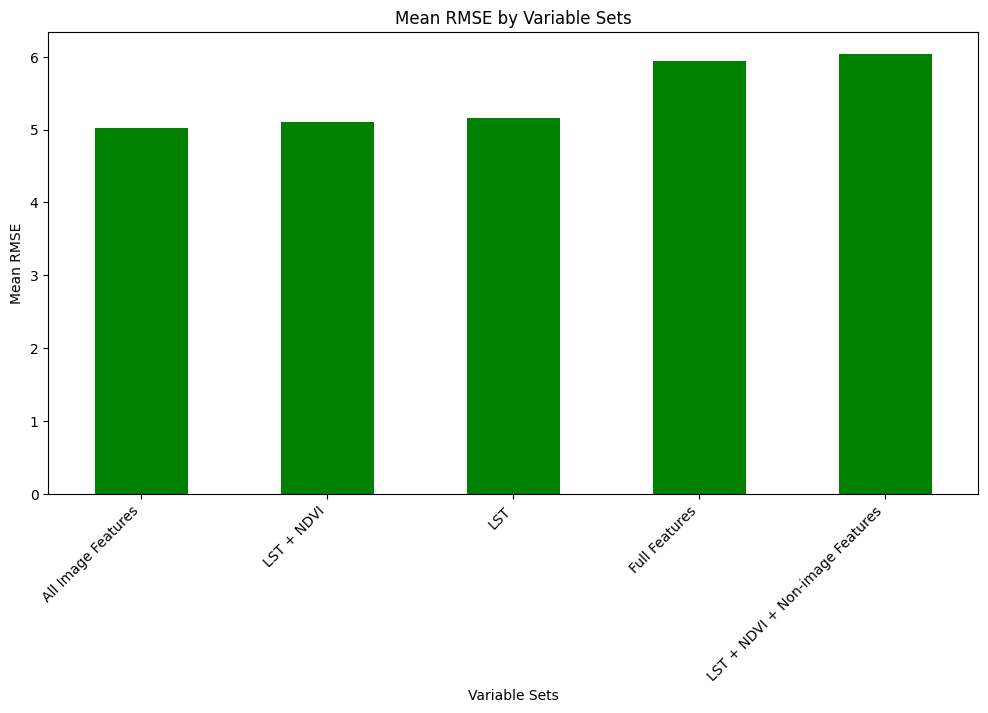

In [112]:
# Agrupar por las variables normalizadas y calcular la media del RMSE
variables_rmse = df_vars.groupby('Normalized Variables')['RMSE'].mean().sort_values()

# Plot mean RMSE for each variable set
plt.figure(figsize=(12, 6))
variables_rmse.plot(kind='bar', color='green')
plt.xlabel('Variable Sets')
plt.ylabel('Mean RMSE')
plt.title('Mean RMSE by Variable Sets')
plt.xticks(rotation=45, ha='right')
plt.show()


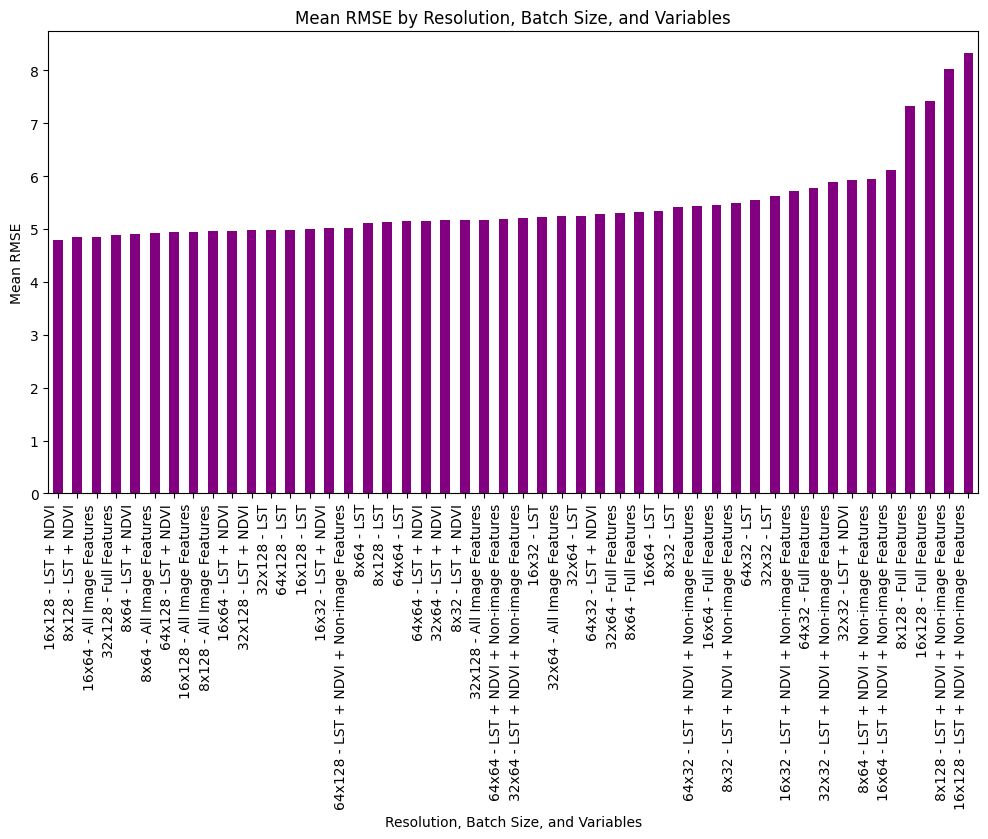

In [113]:
import matplotlib.pyplot as plt

# Crear una nueva columna combinada para Resolution, Batch Size y Variables
df['Resolution-BatchSize-Variables'] = (
    df['Resolution'].astype(str) + 'x' + df['Batch size'].astype(str) + ' - ' + df['Normalized Variables']
)

# Agrupar por la combinación y calcular la media del RMSE
combination_rmse = df.groupby('Resolution-BatchSize-Variables')['RMSE'].mean().sort_values()

# Crear el gráfico
plt.figure(figsize=(12, 6))
combination_rmse.plot(kind='bar', color='purple')
plt.xlabel('Resolution, Batch Size, and Variables')
plt.ylabel('Mean RMSE')
plt.title('Mean RMSE by Resolution, Batch Size, and Variables')
plt.xticks(rotation=90, ha='right')
plt.show()


In [114]:
# RMSE promedio por resolución
rmse_by_resolution = df.groupby('Resolution')['RMSE'].mean().sort_values()
print("RMSE by Resolution:")
print(rmse_by_resolution)

# RMSE promedio por batch size
rmse_by_batch = df.groupby('Batch size')['RMSE'].mean().sort_values()
print("\nRMSE by Batch Size:")
print(rmse_by_batch)

# RMSE promedio por variables
rmse_by_variables = df.groupby('Variables')['RMSE'].mean().sort_values()
print("\nRMSE by Variables:")
print(rmse_by_variables)

# RMSE promedio por la combinación Resolution-BatchSize-Variables
rmse_by_combination = df.groupby('Resolution-BatchSize-Variables')['RMSE'].mean().sort_values()
print("\nRMSE by Combination:")
print(rmse_by_combination)


RMSE by Resolution:
Resolution
64    5.232364
32    5.255824
8     5.559298
16    5.598330
Name: RMSE, dtype: float64

RMSE by Batch Size:
Batch size
64     5.250922
32     5.496905
128    5.504672
Name: RMSE, dtype: float64

RMSE by Variables:
Variables
lst, ndvi, altitude, direction, slope                                4.928192
lst, ndvi, slope, direction, altitude                                5.022007
lst, ndvi, altitude, direction, slope, month, discharge, lat, lon    5.060118
lst, ndvi                                                            5.098569
lst                                                                  5.204344
lst, ndvi, slope, direction, altitude, month, discharge, lat, lon    5.980690
lst, ndvi, month, discharge, lat, lon                                6.036639
Name: RMSE, dtype: float64

RMSE by Combination:
Resolution-BatchSize-Variables
16x128 - LST + NDVI                         4.796014
8x128 - LST + NDVI                          4.856707
16x64 - All I

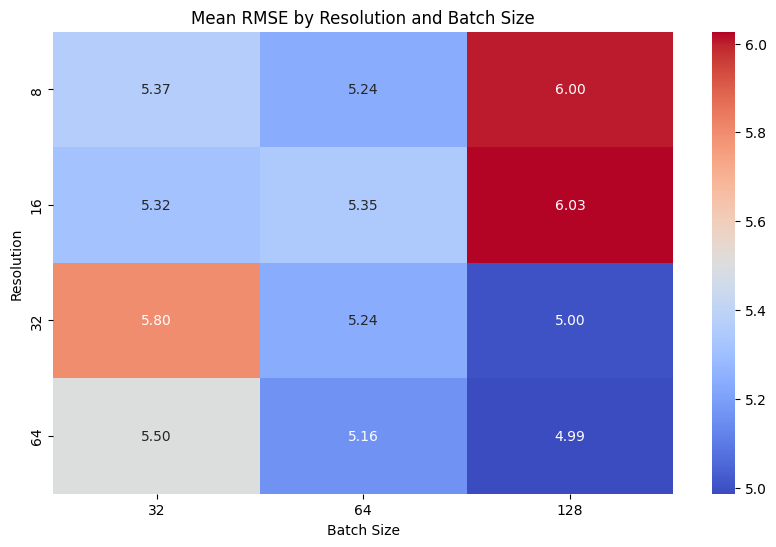

In [115]:
# RMSE promedio por resolución y batch size
rmse_res_batch = df.groupby(['Resolution', 'Batch size'])['RMSE'].mean().unstack()

# Visualizar como heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(rmse_res_batch, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mean RMSE by Resolution and Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Resolution")
plt.show()


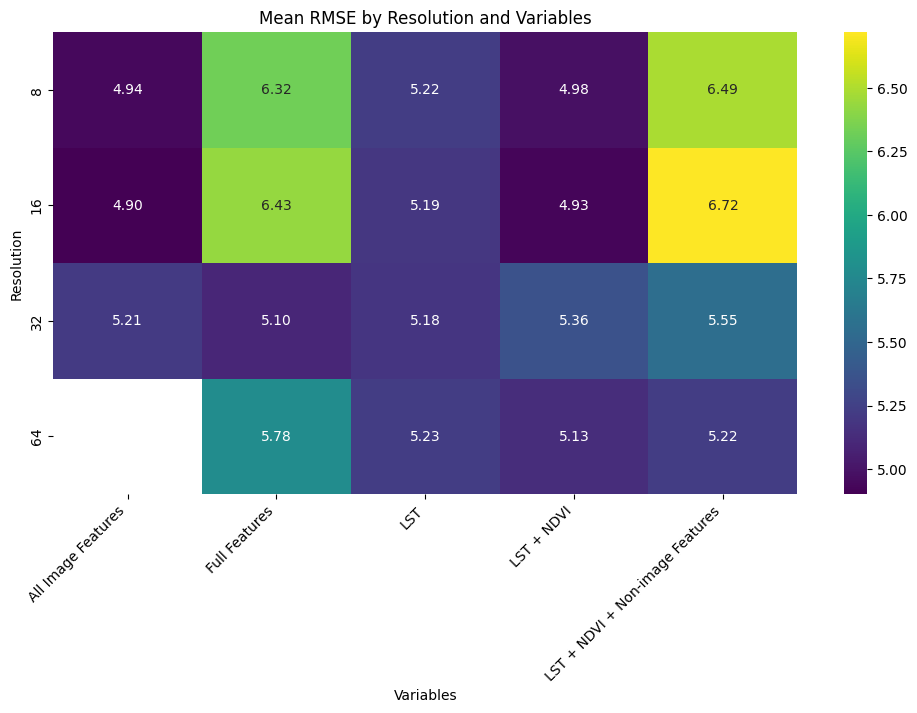

In [116]:
# RMSE promedio por resolución y variables
rmse_res_vars = df.groupby(['Resolution', 'Normalized Variables'])['RMSE'].mean().unstack()

# Visualizar como heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(rmse_res_vars, annot=True, cmap='viridis', fmt=".2f")
plt.title("Mean RMSE by Resolution and Variables")
plt.xlabel("Variables")
plt.ylabel("Resolution")
plt.xticks(rotation=45, ha='right')
plt.show()


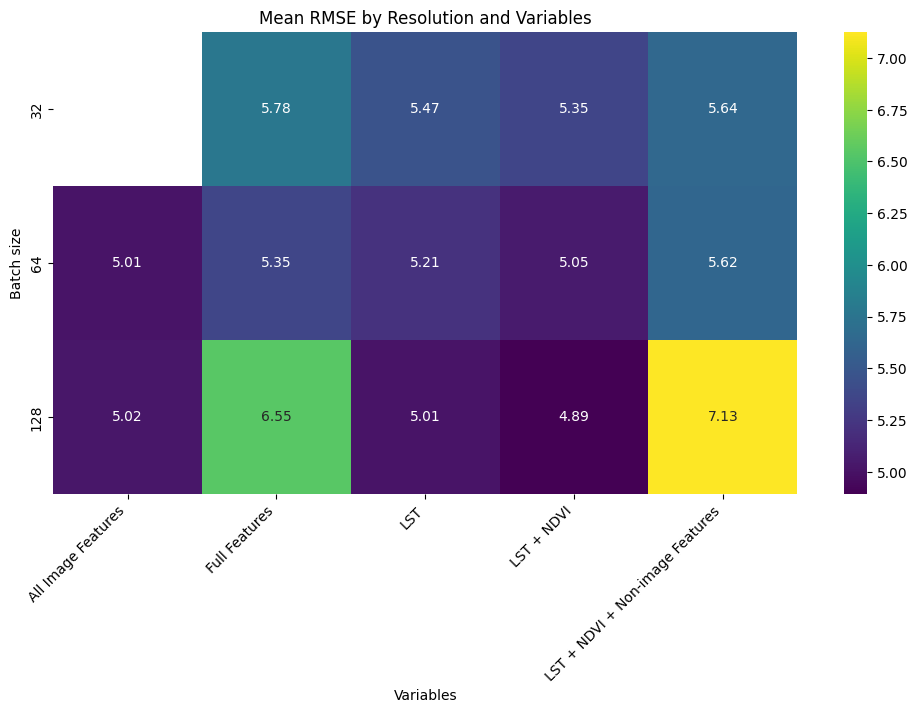

In [117]:
# RMSE promedio por resolución y variables
rmse_res_vars = df.groupby(['Batch size', 'Normalized Variables'])['RMSE'].mean().unstack()

# Visualizar como heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(rmse_res_vars, annot=True, cmap='viridis', fmt=".2f")
plt.title("Mean RMSE by Resolution and Variables")
plt.xlabel("Variables")
plt.ylabel("Batch size")
plt.xticks(rotation=45, ha='right')
plt.show()


In [118]:
df[(df['Normalized Variables']=='All Image Features')&(df.Resolution==32)&(df['Batch size']==128)]


,Experiment,RMSE,Variables,Input,Split,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution,Normalized Variables,Resolution-BatchSize-Variables
46,47,5.058354,"lst, ndvi, slope, direction, altitude",74 cells,stratified,1,Adam,1487,128,139 of 300,2024-11-20,15:55:36,276.64,RMSE,32,All Image Features,32x128 - All Image Features
47,47,5.534033,"lst, ndvi, slope, direction, altitude",74 cells,stratified,2,Adam,1487,128,167 of 300,2024-11-20,16:00:56,335.89,RMSE,32,All Image Features,32x128 - All Image Features
48,48,4.928192,"lst, ndvi, altitude, direction, slope",74 cells,stratified,3,Adam,1487,128,137 of 300,2024-11-20,16:01:00,284.80,RMSE,32,All Image Features,32x128 - All Image Features


Correlations:
            Resolution  Batch size      RMSE
Resolution    1.000000   -0.075800 -0.178994
Batch size   -0.075800    1.000000  0.049566
RMSE         -0.178994    0.049566  1.000000


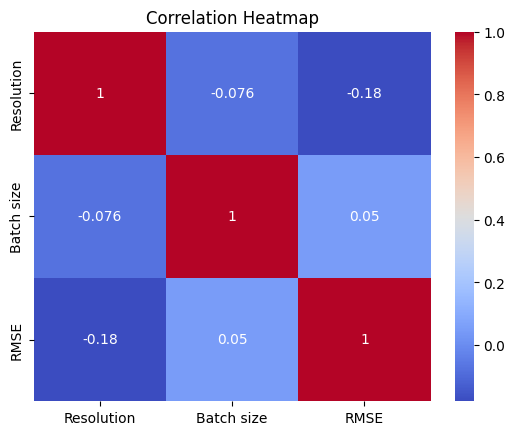

In [119]:
correlations = df[['Resolution', 'Batch size', 'RMSE']].corr()
print("Correlations:")
print(correlations)

# Heatmap de correlaciones
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()
